# Travel Retention Rate

This is fictitious data from a possible company in the travel industry. Most customers only travel with the provider once in a lifetime. However, some customers are returning, these are called repeaters.

In order to optimize the marketing, the customer would like to implement an NBO (Next-Best-Offer) system that predicts which of the previous customers have a high probability of returning in the next year. The goal is to exclude customers with a very low probability of repeating from marketing campaigns and thus reduce costs. E.g. for printed advertisements and catalogues.


Bonus questions:

• As an extension, the company is not only interested in whether, but also where (destination in the booking data) the repeaters will travel to. If you have an approach on how you would identify this “next best destination”, just add this briefly to the text concept. Really just the idea in a few words. PS: this extension gives the case its name as an NBO system.

• As a further enhancement, the company would like to know when the customers would purchase the travel in order to send the customer an additional incentive at the right moment. Here, too, please only briefly one or more approaches in text form.



**Expected output**


o What kind of model should be estimated

o What is the dependent variable and how is it calculated

o What would be the structure of the final data frame used to estimate the model

o What could be possible features, how could they be created

o Which quality checks should be made to check the quality of the variables

o How to test if the model has a good performance

## Installing and Loading libraries

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install -U scikit-learn
#!pip install missingno
#!pip install -U imbalanced-learn
#!pip install seaborn
#!pip install xgboost

In [2]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier,
)
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from xgboost import XGBClassifier


pd.set_option("display.max_columns", None)



## Loading raw data as provided

In [3]:
df_variables_explained = pd.read_excel("Codebook.xlsx")
df_customer = pd.read_csv("kunden_daten.csv", sep=";", encoding="latin-1")
df_booking = pd.read_csv("buchung_daten.csv", sep=";", encoding="latin-1")
df_export = pd.read_csv("export_regio.csv", sep=";", encoding="latin-1")

Selecting relevant columns based on preliminary analysis; merging customer and booking details to form a complete metadata on each customer

In [4]:
columns_customer = [
    "kunden_id",
    "anrede",
    "lkz",
    "keine_werbung",
    "club_programm",
    "sprache_deutsch",
    "jahrgangsalter_klassiert",
]

columns_booking = [
    "kunden_id",
    "buchungsnr",
    "buchungsdatum",
    "anreisetag",
    "abreisetag",
    "naechte_insgesamt",
    "gebuchte_naechte",
    "personen_anzahl",
    "gesamtpreis",
    "saison",
    "zimmerarten",
    "entfernung",
    "zusatzleistung",
    "destination",
    "buchung_partner_reisebuero",
]


df_customer = df_customer[columns_customer]
df_booking = df_booking[columns_booking]

df_metadata = pd.merge(
    df_customer, df_booking, left_on="kunden_id", right_on="kunden_id"
)


# Data preparation  (features)

(i) Categorical features

In [5]:
# choosing 4 categorical variables >> customer id(kunden_id), gender(anrede), country(lkz), age group(jahrgangsalter_klassiert)
df_features_categorical = (
    df_metadata[["kunden_id", "anrede", "lkz", "jahrgangsalter_klassiert"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

(ii) Numerical features

In [6]:
df_features_numerical = df_metadata[
    [
        "kunden_id",                       # customer_id
        "keine_werbung",                   # no advertising (categorial by nature)
        "club_programm",                   # club program   (categorial by nature)
        "sprache_deutsch",                 # speaks german  (categorial by nature)
        "gebuchte_naechte",                # booked nights  
        "personen_anzahl",                 # no of persons
        "gesamtpreis",                     # total price of the booking
        "entfernung",                      # distance of the journey
        "zusatzleistung",                  # additional services
    ]
]

# price per customer for booked nights in a trip
df_features_numerical["price_for_booked_nights"] = (
    df_features_numerical["gesamtpreis"] / df_features_numerical["personen_anzahl"]
)


# aggregating the data customer wise
df_features_numerical = (
    df_features_numerical.groupby("kunden_id")
    .agg(
        {
            "keine_werbung": "median",       
            "club_programm": "median",       
            "sprache_deutsch": "median",     
            "gebuchte_naechte": "sum",
            "entfernung": "sum",
            "zusatzleistung": "sum",
            "price_for_booked_nights": "sum",
        }
    )
    .reset_index()
)

In [7]:
# combining and getting the features dataframe
df_features =  pd.merge(df_features_categorical, df_features_numerical, on='kunden_id')

# Data Preparation (target variable)

Here, we create the target variable called as Retention; it tell if a customer is repeating or not. The opposite of this is Churn rate :: the rate at which customers leave the service. It can be due to switching to a new service, cancelling subscription, not satisfied with the service etc. In order to calculate it, we follow:

1. Find the **time period(in months)** between first booking date and last booking date for each customer
2. Find the **average time(in months)** required for 1 booking which simply is  **time period(in months) / no of bookings** 
3. Find the **time period of inactivity** for each customer :**maximum of last booking date among all the customers - last booking date of a customer**
4. Now we need to define a rule which will depend on the business : **how many frequencies we can skip
   , such that we can define a customer as repeating or churned.**
5. Here, in this case I choose the **skipping frequency metric** to be 7. This is heavily dependent on the business use case and how much flexibility the company can give to a customer.

Example : Let's say a customer books a trip in 2 months(average time) and we choose the skipping frequency to be 2. So, if the customer doesn't book for 4 months in a row, we define that customer as churned.

It's little bit hard to define this paramter. A customer cannote be labelled as churn because they stopped booking for some time. There might be many reasons such as seasonal, traveling less frequently, economic situation etc..

In [8]:
# choosing the required columns to formulate the retention/churn target variable
df = df_metadata[
    [
        "kunden_id",
        "buchungsnr",
        "buchungsdatum",
        "anreisetag",
        "abreisetag",
    ]
]

In [9]:
# converting time to datetime
df['buchungsdatum'] = pd.to_datetime(df['buchungsdatum'])
df['anreisetag'] = pd.to_datetime(df['anreisetag'])
df['abreisetag'] = pd.to_datetime(df['abreisetag'])

# no of days in the trip
df['num_of_days_in_trip'] = (df['abreisetag'] - df['anreisetag']).dt.days

# the date from which the churn rate is calculated i.e., the latest booking date
current_date = df['buchungsdatum'].max()

In [10]:
# calculating the first date of purchase, last date of purchase and the no of bookings for each customer.

df_last_booking = (
    df.groupby("kunden_id")
    .agg({"buchungsdatum": "max"})
    .reset_index()
    .rename(columns={"buchungsdatum": "last_booking_date"})
)

df_first_booking = (
    df.groupby("kunden_id")
    .agg({"buchungsdatum": "min"})
    .reset_index()
    .rename(columns={"buchungsdatum": "first_booking_date"})
)


df_num_of_bookings = (
    df.groupby("kunden_id")
    .agg({"buchungsdatum": "count"})
    .reset_index()
    .rename(columns={"buchungsdatum": "no_of_bookings"})
)


In [11]:
# merging the above data
df_target = pd.merge(
    pd.merge(df_first_booking, df_last_booking, on="kunden_id"),
    df_num_of_bookings,
    on="kunden_id",
)

# time period in months between the first and last purchase
df_target["period_bw_first_and_last_booking"] = (
    (df_target["last_booking_date"] - df_target["first_booking_date"]).dt.days
    / 365
    * 12
)

# average time period in months for a booking
df_target["avg_months_per_booking"] = (
    df_target["period_bw_first_and_last_booking"] / df_target["no_of_bookings"]
)

# time period of inactivity 
df_target["months_from_last_purchase"] = (
    (current_date - df_target["last_booking_date"]).dt.days / 365
) * 12


In [12]:
# business rule defined previously. 
skipping_param = 7

df_target["Retention"] = np.where(
    df_target["no_of_bookings"] == 1,
    "Single_Booking",
    np.where(
        df_target["avg_months_per_booking"] * skipping_param
        < df_target["months_from_last_purchase"],
        "Churn",
        "Repeater",
    ),
)

# removing customers who booked only once in the current year (2019) since we need atleast > 1 year of time 
#to see the customer behaviour. These customers might become active again later.
df_target = df_target[
    ~(
        (df_target["no_of_bookings"] == 1)
        & (df_target["first_booking_date"].dt.year == 2019)
    )
].reset_index(drop=True)


df_target = df_target[['kunden_id', 'no_of_bookings','Retention']]

# Creating the final dataframe

In [13]:
# merging the features and target on customer id
df_model = pd.merge(df_features, df_target, on="kunden_id")

# also labelling one time booking customers as churn
df_model["Retention"] = df_model["Retention"].str.replace("Single_Booking", "Churn")

In [14]:
# checking null values
df_model.isnull().sum()

kunden_id                       0
anrede                      17975
lkz                         18536
jahrgangsalter_klassiert    27834
keine_werbung                   0
club_programm                   0
sprache_deutsch               991
gebuchte_naechte                0
entfernung                      0
zusatzleistung                  0
price_for_booked_nights         0
no_of_bookings                  0
Retention                       0
dtype: int64

<AxesSubplot:>

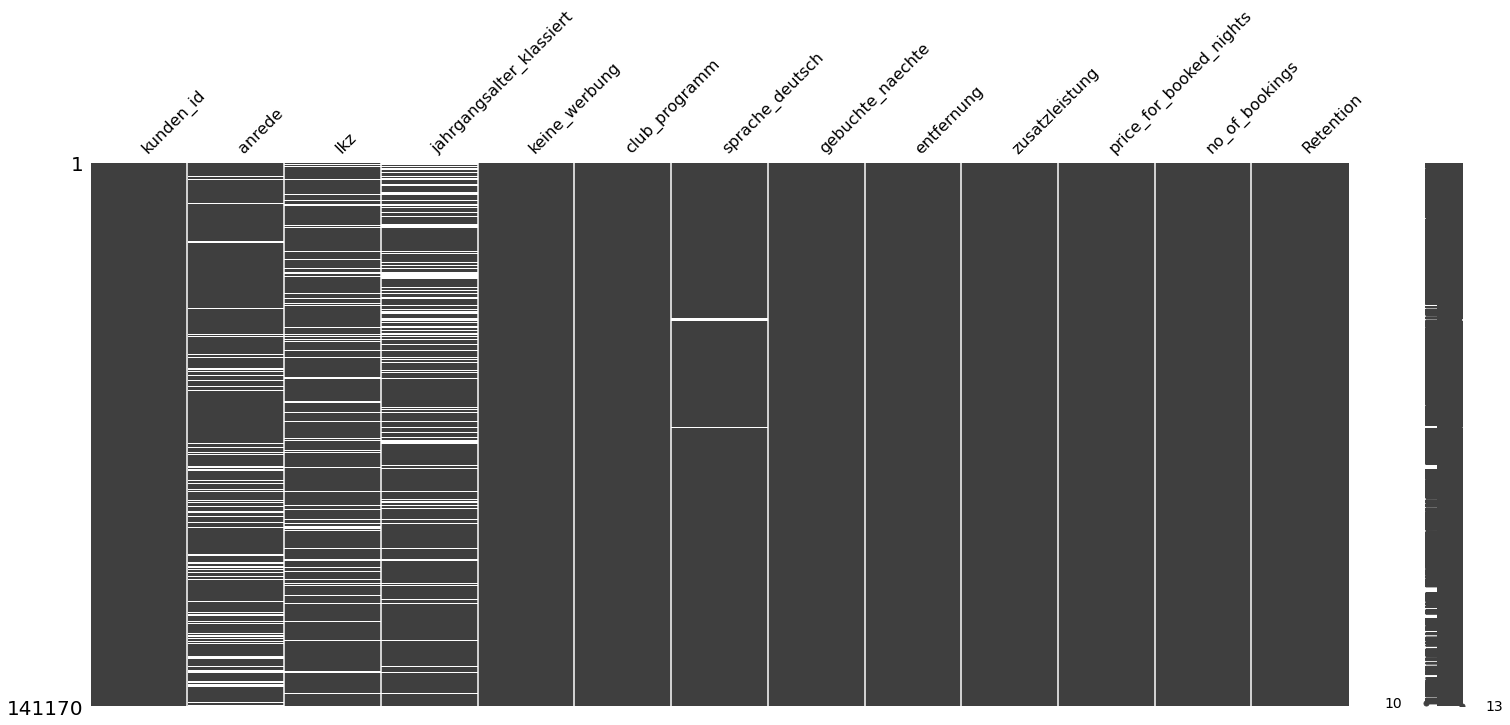

In [15]:
# displaying null values
import missingno as msno
msno.matrix(df_model)

We see majority of null values in 'anrede', 'lkz' and 'jahrgangsalter_klassiert'.

In [16]:
# filling  missing values
# 1. for anrede, we label the null vales with 'Unknown Gender'; we also remove 3 samples with Firma as the gender.
# 2. for lkz, we label the null vales with 'Unknown Country'
# 3. for age-group, we label the null vales with 'Unknown Age Group'
# 4. for speaking german, we replace the null values with 1.0(since its the majority 99.29)

# 1
df_model["anrede"] = df_model["anrede"].fillna("Unknown Gender")
firma_cust_id = df_model[df_model["anrede"] == "Firma"]["kunden_id"].values
df_model = df_model[~df_model["kunden_id"].isin(firma_cust_id)].reset_index(drop=True)


# 2
df_model["lkz"] = df_model["lkz"].fillna("Unknown Country")

# 3
df_model["jahrgangsalter_klassiert"] = df_model["jahrgangsalter_klassiert"].fillna(
    "Unknown Age Group"
)

# 4
df_model["sprache_deutsch"] = df_model["sprache_deutsch"].fillna(1.0)



In [17]:
# to simplify, we can replace countries other than DE as "Outside DE" thus reducing the categories.

cn_list = []

for i in df_model["lkz"]:
    if i == "DE":
        cn_list.append("DE")
    elif i == "Unknown Country":
        cn_list.append("Unknown Country")
    else:
        cn_list.append("Outside DE")

df_model["lkz"] = cn_list

In [18]:
# also label encoding the target variable "Retention"
# Churn = 0
# Repeater = 1
df_model['Retention'] = df_model['Retention'].apply(lambda x: 0 if x == "Churn" else 1)

In [19]:
# dropping the kunden_id column and removing duplicates
df_model = df_model.drop(['kunden_id'], axis=1)
df_model = df_model.drop_duplicates().reset_index(drop=True)

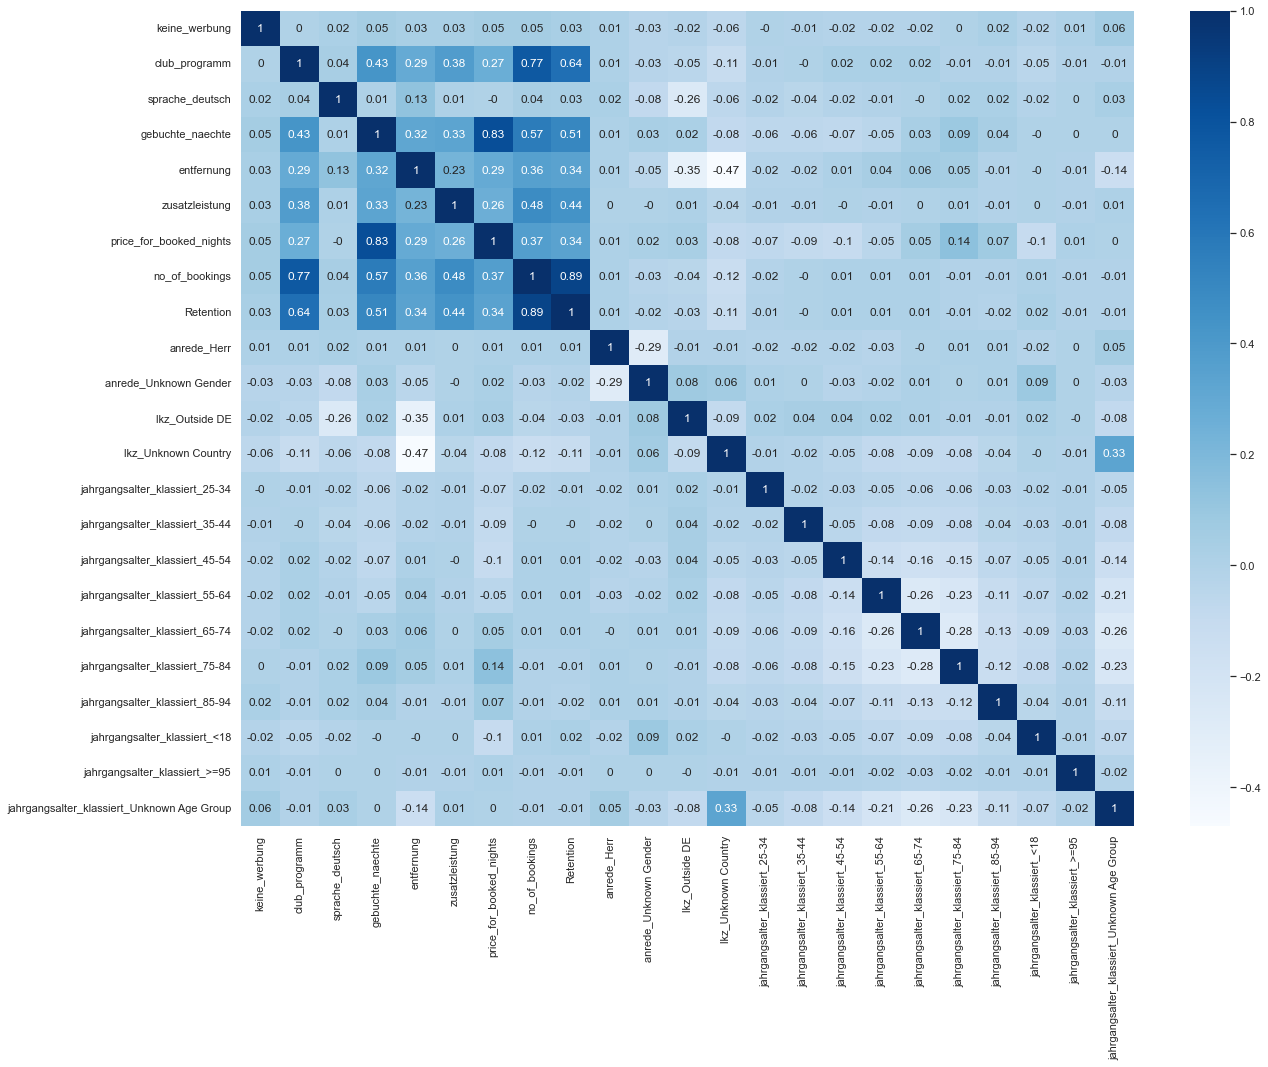

In [20]:
# Plotting the correlation matrix
df_coded = pd.get_dummies(df_model,drop_first=True)
sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(np.round(df_coded.corr(method ='spearman'), 2), annot=True,  cmap='Blues');

We see that no of bookings and club_programme(subscription) are highly correlated with the retention rate.

# Modeling and Evaluation

In [21]:
X = df_model.drop("Retention", axis=1)
y = df_model["Retention"]
X = pd.get_dummies(X,drop_first=True)

# removing special characters from feature names
X.columns = X.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

In [22]:
# splitting the data to enable equal proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [23]:
# defining function to train, predict and get the evaluation metrics
def fit_evaluate(clf, X_train, X_test, y_train, y_test):
    # fit model to training data
    clf.fit(X_train, y_train)
    # make predictions for test data
    y_pred = clf.predict(X_test)
    # print evaluation
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix: \n")
    s = sns.heatmap(
        confusion_matrix(y_test, y_pred), annot=True, fmt="g", cmap="YlGnBu"
    )
    s.set(xlabel="Predicted class", ylabel="True class")


### Logistic Regression

* Logistic regression * 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     34984
           1       0.79      0.76      0.78      4073

    accuracy                           0.95     39057
   macro avg       0.88      0.87      0.87     39057
weighted avg       0.95      0.95      0.95     39057


Confusion Matrix: 



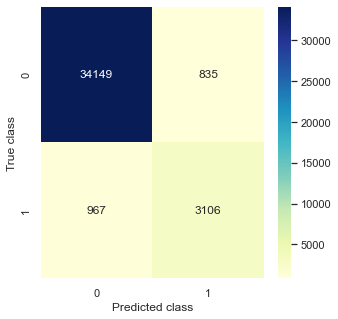

In [24]:
sns.set(rc={'figure.figsize':(5,5)})
model_LR = LogisticRegression()
print('* Logistic regression * \n')
fit_evaluate(model_LR, X_train, X_test, y_train, y_test)

Although we should use some data balancing technique like undersampling, oversampling or SMOTE, baseline logistic regression gives an okayish recall, precision and F1 score for the minority class

### Random Forest

*Random Forest Classifier * 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     34984
           1       0.84      0.96      0.90      4073

    accuracy                           0.98     39057
   macro avg       0.92      0.97      0.94     39057
weighted avg       0.98      0.98      0.98     39057


Confusion Matrix: 



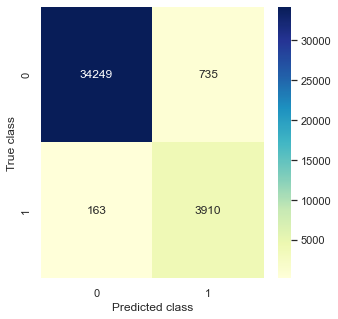

In [25]:
model_RF = RandomForestClassifier()
print('*Random Forest Classifier * \n')
fit_evaluate(model_RF, X_train, X_test, y_train, y_test)

Although,the performance has increased quite a but from LR but the precision is still lower at 84% for the minorty class, 16% of the churned customers are labeled as repeaters. The company would like to increase precison so that they don't waste marketing money on these 16% of the customers.

### XGBoost

*XGBoost Classifier * 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     34984
           1       0.85      0.96      0.90      4073

    accuracy                           0.98     39057
   macro avg       0.92      0.97      0.94     39057
weighted avg       0.98      0.98      0.98     39057


Confusion Matrix: 



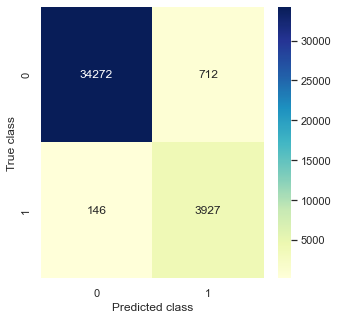

In [26]:
model_XGB = XGBClassifier()
print('*XGBoost Classifier * \n')
fit_evaluate(model_XGB, X_train, X_test, y_train, y_test)

Its a very small improvement, XGBoost gives similar results with Precesion of 85% on the minority class

In [27]:
print("Metrics for the minority class (repeat customer)")
dict = {
    "Precision": [0.79, 0.84, 0.85],
    "Recall": [0.76, 0.96, 0.96],
    "F1-Score": [0.78, 0.90, 0.90],
}
metrics = pd.DataFrame(dict, index=["Logistic Regression", "Random Forest", "XGBoost"])
metrics


Metrics for the minority class (repeat customer)


,Precision,Recall,F1-Score
Logistic Regression,0.79,0.76,0.78
Random Forest,0.84,0.96,0.90
XGBoost,0.85,0.96,0.90


# KPIs


1. We would like to increase the Precision of minority class in order to reduce the maketings costs. The company don't want to send adverts, catalogues to these 15% of churned customers which are predicted as repeaters. The estimated model can be improved on this aspect either by hyparameter tuning, changing the skipping  frequency to formulate the target variable etc.


2. Churned rate : The model works well for the majority class(churned), although the churned rate should be monitored regularly across a year. In order to reduce the churn rate, firstly we need to identify the causes and create solutions around it. For example, we can identify customers who book once a year and then the company can offer discounts if they book their next trip before a particular date. Then, we do a cohurt analysis and see that if they are less likely to churn or not.





The estimated model in this notebook gives a decent result although it can be improved by performing a cohurt analysis and then use that insights to improve the data quality.